In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from collections import Counter

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


## 1.1 Loading Data

In [ ]:
data = pd.read_csv('preprocessed_data.csv')
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:

from collections import Counter
my_counter = Counter()
for word in data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [ ]:
print("Number of data points in train data\n", data.shape)

print("\nThe attributes of data :", data.columns.values)

Number of data points in train data
 (109248, 9)

The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


In [ ]:
print("Number of data points in train data \n", data.shape)
print("\n",data.columns.values)
data.head(6)

Number of data points in train data 
 (109248, 9)

 ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
5,ca,mrs,grades_3_5,6,1,math_science history_civics,mathematics socialsciences,it end school year routines run course student...,102.50


Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)

Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


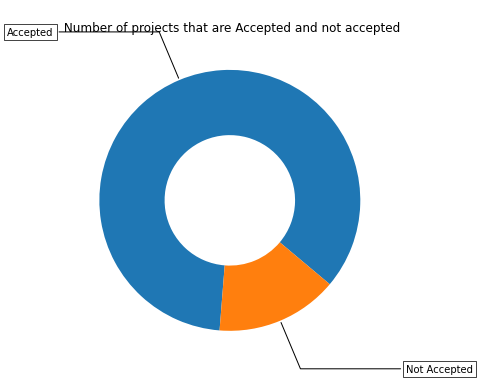

In [ ]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("\nNumber of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("\n Number of projects that are Accepted and not accepted")

plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

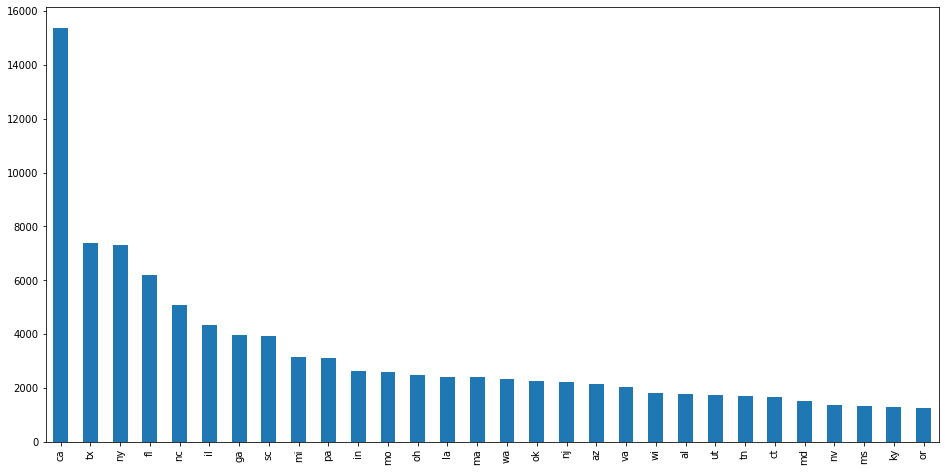

In [ ]:
data['school_state'].value_counts().head(30).plot.bar()

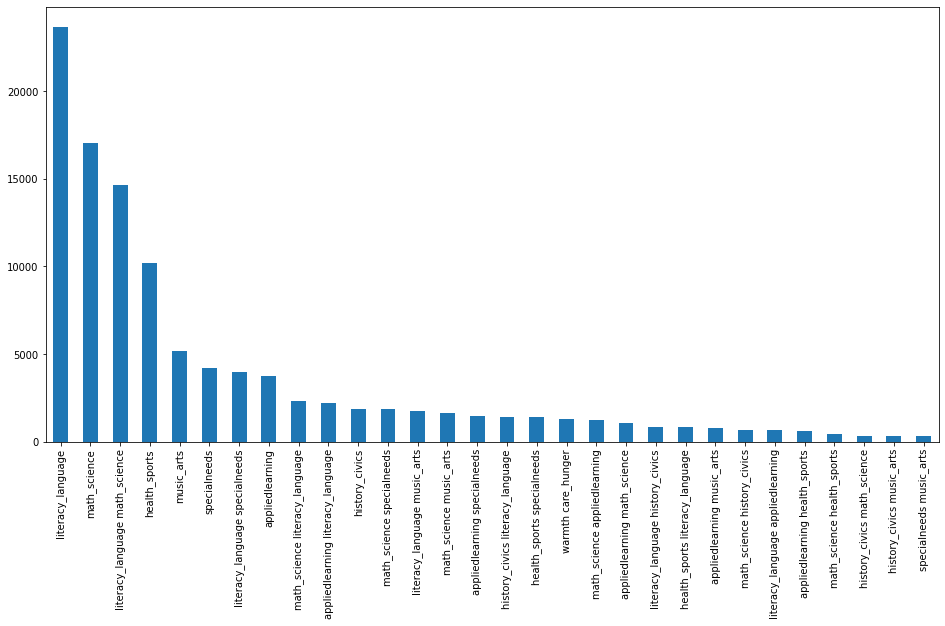

In [ ]:
data['clean_categories'].value_counts().head(30).plot.bar()

In [ ]:
y_value_counts = data['project_is_approved'].value_counts()
print(y_value_counts)

1    92706
0    16542
Name: project_is_approved, dtype: int64


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:

# Combining all the above stundents 
def Text_cleaner(data):
    from tqdm import tqdm
    preprocessed_essays = []
    # tqdm is for printing the status bar
    for sentance in tqdm(data.values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('nan',' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_essays.append(sent.lower().strip())
    return preprocessed_essays

In [ ]:
# after preprocesing
preprocessed_essays=Text_cleaner(data['essay'])

100%|██████████| 109248/109248 [00:45<00:00, 2394.10it/s]


In [ ]:
data['essay'] = preprocessed_essays


In [ ]:
# similarly you can preprocess the titles also
preprocessed_project_title=Text_cleaner(data['project_title'])

In [ ]:
z=data['price']
z

0         725.05
1         213.03
2         329.00
3         481.04
4          17.74
           ...  
109243    143.36
109244    268.57
109245    399.00
109246    287.73
109247      5.50
Name: price, Length: 109248, dtype: float64

In [ ]:

#https://stackoverflow.com/questions/29763620/how-to-select-all-columns-except-one-column-in-pandas
X=data.loc[:, data.columns != 'project_is_approved']
y=data['project_is_approved']
X.shape

(109248, 9)

### **Splitting data into Test,Train,CV**

In [ ]:
#Splitting data into Test,Train,CV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test=train_test_split(X, y, test_size=0.33,stratify = y)
# X_train,X_cv,y_train,y_cv=train_test_split(X_train, y_train, test_size=0.3, random_state=0)


print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(73196, 9)
(36052, 9)
(73196,)
(36052,)


In [ ]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values)
feature_names_bow=[]
feature_names_tfidf=[]
# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories=vectorizer.transform(X_train['clean_categories'].values)
X_test_clean_categories=vectorizer.transform(X_test['clean_categories'].values)


print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",X_train_clean_categories.shape)
feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

['appliedlearning', 'appliedlearninghealth_sports', 'appliedlearninghistory_civics', 'appliedlearningliteracy_language', 'appliedlearningmath_science', 'appliedlearningmusic_arts', 'appliedlearningspecialneeds', 'appliedlearningwarmthcare_hunger', 'health_sports', 'health_sportsappliedlearning', 'health_sportshistory_civics', 'health_sportsliteracy_language', 'health_sportsmath_science', 'health_sportsmusic_arts', 'health_sportsspecialneeds', 'health_sportswarmthcare_hunger', 'history_civics', 'history_civicsappliedlearning', 'history_civicshealth_sports', 'history_civicsliteracy_language', 'history_civicsmath_science', 'history_civicsmusic_arts', 'history_civicsspecialneeds', 'history_civicswarmthcare_hunger', 'literacy_language', 'literacy_languageappliedlearning', 'literacy_languagehealth_sports', 'literacy_languagehistory_civics', 'literacy_languagemath_science', 'literacy_languagemusic_arts', 'literacy_languagespecialneeds', 'literacy_languagewarmthcare_hunger', 'math_science', 'm

In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_sub_categories=vectorizer.transform(X_train['clean_subcategories'].values)
X_test_clean_sub_categories=vectorizer.transform(X_test['clean_subcategories'].values)


print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",X_train_clean_sub_categories.shape)
feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

['appliedsciences', 'appliedsciencescharactereducation', 'appliedsciencescivics_government', 'appliedsciencescollege_careerprep', 'appliedsciencescommunityservice', 'appliedsciencesearlydevelopment', 'appliedscienceseconomics', 'appliedsciencesenvironmentalscience', 'appliedsciencesesl', 'appliedsciencesextracurricular', 'appliedsciencesfinancialliteracy', 'appliedsciencesforeignlanguages', 'appliedsciencesgym_fitness', 'appliedscienceshealth_lifescience', 'appliedscienceshealth_wellness', 'appliedscienceshistory_geography', 'appliedsciencesliteracy', 'appliedsciencesliterature_writing', 'appliedsciencesmathematics', 'appliedsciencesmusic', 'appliedsciencesnutritioneducation', 'appliedsciencesother', 'appliedsciencesparentinvolvement', 'appliedsciencesperformingarts', 'appliedsciencessocialsciences', 'appliedsciencesspecialneeds', 'appliedsciencesteamsports', 'appliedsciencesvisualarts', 'appliedscienceswarmthcare_hunger', 'charactereducation', 'charactereducationcivics_government', 'c

In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_skl_state=vectorizer.transform(X_train['school_state'].values)
X_test_skl_state=vectorizer.transform(X_test['school_state'].values)


print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",X_train_skl_state.shape)
feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encodig  (73196, 51)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values.astype("U"))

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix=vectorizer.transform(X_train['teacher_prefix'].values.astype("U"))
X_test_teacher_prefix=vectorizer.transform(X_test['teacher_prefix'].values.astype("U"))


print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",X_train_teacher_prefix.shape)
feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encodig  (73196, 5)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_level=vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_level=vectorizer.transform(X_test['project_grade_category'].values)


print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",X_train_grade_level.shape)
feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Shape of matrix after one hot encodig  (73196, 4)


### **Vectorizing Text data**
Bag of word

In [ ]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
bow_essay_vectorizer = CountVectorizer(min_df=10)
bow_essay_vectorizer.fit(X_train['essay'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow=bow_essay_vectorizer.transform(X_train['essay'].values)
X_test_essay_bow=bow_essay_vectorizer.transform(X_test['essay'].values)


print("Shape of matrix after one hot encodig ",X_train_essay_bow.shape)
print("Shape of matrix after one hot encodig ",X_test_essay_bow.shape)

feature_names_bow.extend(bow_essay_vectorizer.get_feature_names())

Shape of matrix after one hot encodig  (73196, 14165)
Shape of matrix after one hot encodig  (36052, 14165)


### **TFIDF vectorizer**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essay'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf=vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf=vectorizer.transform(X_test['essay'].values)


print("Shape of matrix after one hot encodig ",X_train_essay_tfidf.shape)
feature_names_tfidf.extend(vectorizer.get_feature_names())


Shape of matrix after one hot encodig  (73196, 14165)


In [ ]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_standardized = normalizer.transform(X_train['price'].values.reshape(1,-1))
# X_cv_price_standardized = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_standardized = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_standardized.shape, y_train.shape)
# print(X_cv_price_standardized.shape, y_cv.shape)
print(X_test_price_standardized.shape, y_test.shape)
print("+-------+"*10)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)
+-------++-------++-------++-------++-------++-------++-------++-------++-------++-------+


In [ ]:
X_train_price_standardized = X_train_price_standardized.reshape(-1,1)
# X_cv_price_standardized = X_cv['price'].values.reshape(-1,1)
X_test_price_standardized = X_test_price_standardized.reshape(-1,1)

In [ ]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
# X_cv_prev_proj = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_proj = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_prev_proj.shape, y_train.shape)
# print(X_cv_prev_proj.shape, y_cv.shape)
print(X_test_proj.shape, y_test.shape)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)


In [ ]:
X_train_prev_proj = X_train_prev_proj.reshape(-1,1)
# X_cv_prev_proj = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_proj = X_test_proj.reshape(-1,1)

## Merging all the above features

--we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_bow = hstack((X_train_clean_categories, X_train_clean_sub_categories,X_train_skl_state,X_train_teacher_prefix,
            X_train_grade_level,X_train_prev_proj,X_train_price_standardized,
            X_train_essay_bow
            )).tocsr()


X_test_bow = hstack((X_test_clean_categories, X_test_clean_sub_categories,X_test_skl_state,X_test_teacher_prefix,
            X_test_grade_level,X_test_proj,X_test_price_standardized,
            X_test_essay_bow,
            )).tocsr()





print(X_train_bow.shape)
print(X_test_bow.shape)


(73196, 14664)
(36052, 14664)


In [ ]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_tfidf = hstack((X_train_clean_categories, X_train_clean_sub_categories,X_train_skl_state,X_train_teacher_prefix,
            X_train_grade_level,X_train_prev_proj,X_train_price_standardized,
            X_train_essay_tfidf
            )).tocsr()


X_test_tfidf = hstack((X_test_clean_categories, X_test_clean_sub_categories,X_test_skl_state,X_test_teacher_prefix,
            X_test_grade_level,X_test_proj,X_test_price_standardized,
            X_test_essay_tfidf
            )).tocsr()


print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(73196, 14664)
(36052, 14664)


## **Naive Bayes**

Appling NB() on different kind of featurization as mentioned in the instructions

Applying Naive Bayes on BOW

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True)

clf.fit(X_train_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
test_auc = clf.cv_results_['mean_test_score'] 
test_auc_std = clf.cv_results_['std_test_score']

In [ ]:
#Output of GridSearchCV
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('\n\n')
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.7031023139780251
k value with best score:  {'alpha': 0.5}
Train AUC scores
[0.80765159 0.80674006 0.80621976 0.80462009 0.80372402 0.80101006
 0.79949707 0.79481499 0.79203875 0.78169359 0.77364495 0.7337124
 0.70484898 0.62252653 0.52000368 0.50001292 0.50004511 0.5
 0.50002097 0.50017783]
CV AUC scores
[0.68100622 0.68400124 0.68542913 0.68902898 0.69067896 0.69461905
 0.69632507 0.70007263 0.70148229 0.70310231 0.70180987 0.68292428
 0.66503933 0.60654816 0.51596703 0.50001293 0.50004513 0.5
 0.50002098 0.50017787]


In [ ]:
def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

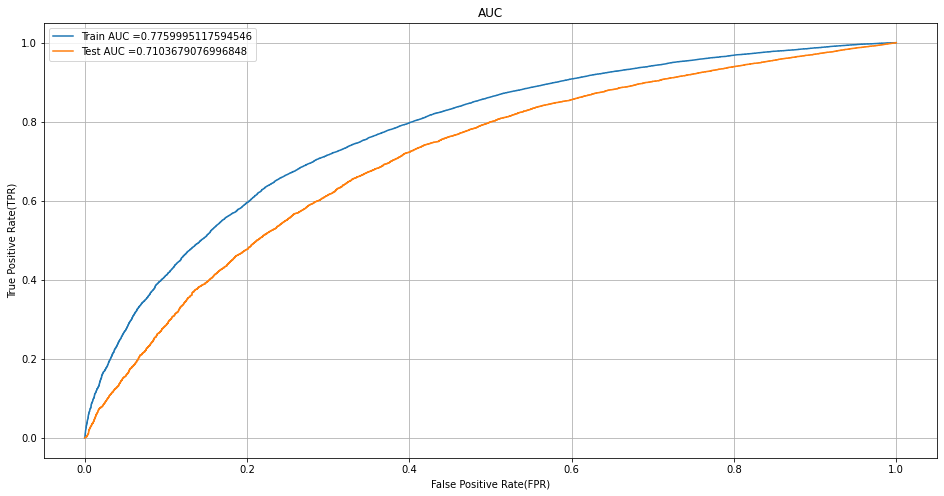

In [ ]:
from sklearn.metrics import roc_curve, auc

nb_bow = MultinomialNB(alpha = clf.best_params_['alpha'],class_prior = [0.5,0.5])

nb_bow.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = pred_prob(nb_bow,X_train_bow)
y_test_pred = pred_prob(nb_bow,X_test_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.5032520958333053 for threshold 0.488


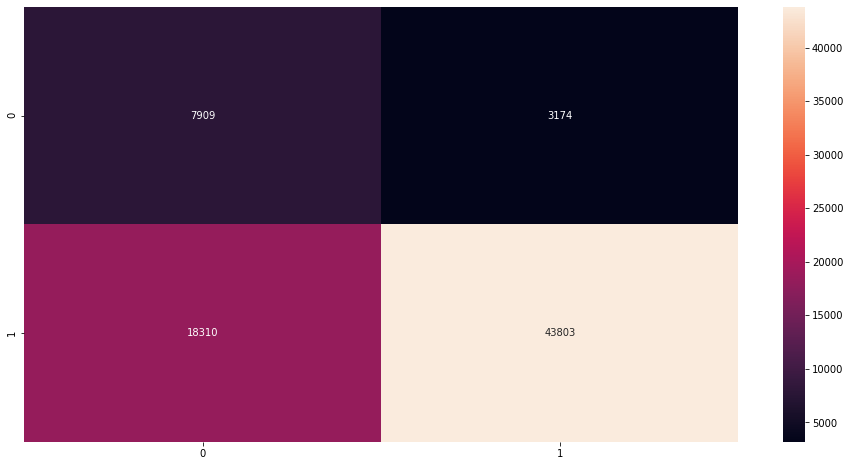

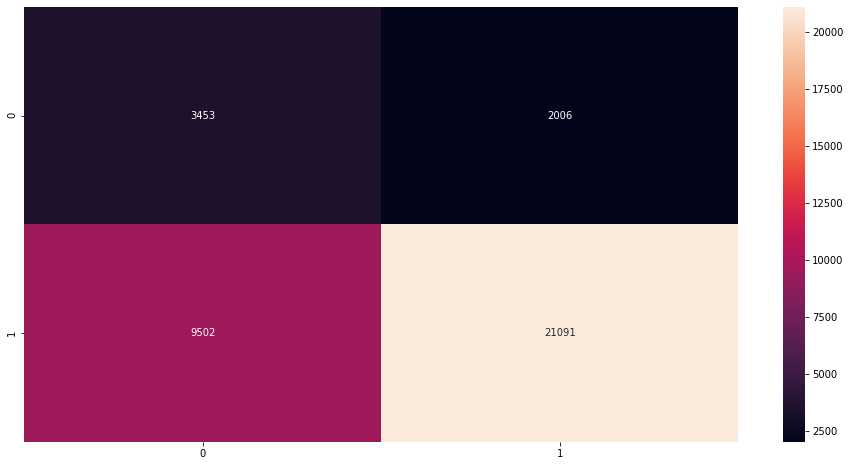

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax)


fig = plt.figure()
ax1 = fig.add_subplot(111)
cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax1)

In [ ]:
neg_class_prob_sorted = nb_bow.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = nb_bow.feature_log_prob_[1, :].argsort()   #class1

In [ ]:
print(neg_class_prob_sorted[-10:],pos_class_prob_sorted[-10:])

[14519  8878  8228  6507  7792  9015  2875  7796 11572 12719] [14519  8878  8228  6507  7792  9015  2875  7796 11572 12719]


In [ ]:
print('Top 10 features from negative class:')
print(np.take(feature_names_bow, neg_class_prob_sorted[-10:]))
print('----'*50)
print('\n\nTop 10 features from positive class:')
print(np.take(feature_names_tfidf, pos_class_prob_sorted[-10:]))

Top 10 features from negative class:
['workbook' 'neediest' 'maple' 'helper' 'learner' 'notably' 'classwork'
 'learniture' 'schooler' 'studies']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Top 10 features from positive class:
['workbook' 'neediest' 'maple' 'helper' 'learner' 'notably' 'classwork'
 'learniture' 'schooler' 'studies']


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True)

clf.fit(X_train_tfidf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']

In [ ]:
#Output of GridSearchCV
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('='*75)
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.6656149862268059
k value with best score:  {'alpha': 0.05}
Train AUC scores
[0.79033415 0.78910496 0.78837744 0.78603591 0.78465737 0.78015965
 0.77738655 0.76689881 0.75885423 0.71991889 0.69049958 0.61307049
 0.58722637 0.55090408 0.54268021 0.53351009 0.53197079 0.53082074
 0.53014616 0.5293167 ]
CV AUC scores
[0.64959881 0.65219535 0.6535107  0.65693939 0.65851609 0.66219452
 0.66361062 0.66561499 0.66499881 0.65152569 0.6359703  0.58752091
 0.56999316 0.54414701 0.53806533 0.53158074 0.53063975 0.52998554
 0.5295392  0.52885703]


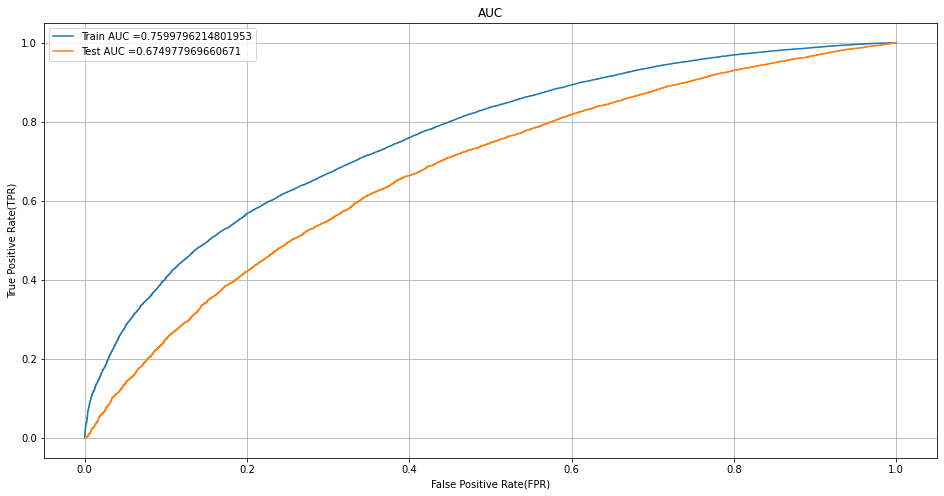

In [ ]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb_tfidf = MultinomialNB(alpha = clf.best_params_['alpha'],class_prior = [0.5,0.5])

nb_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = pred_prob(nb_tfidf, X_train_tfidf)    
y_test_pred = pred_prob(nb_tfidf, X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

Train Data confusion matrix
the maximum value of tpr*(1-fpr) 0.46909285793074185 for threshold 0.518


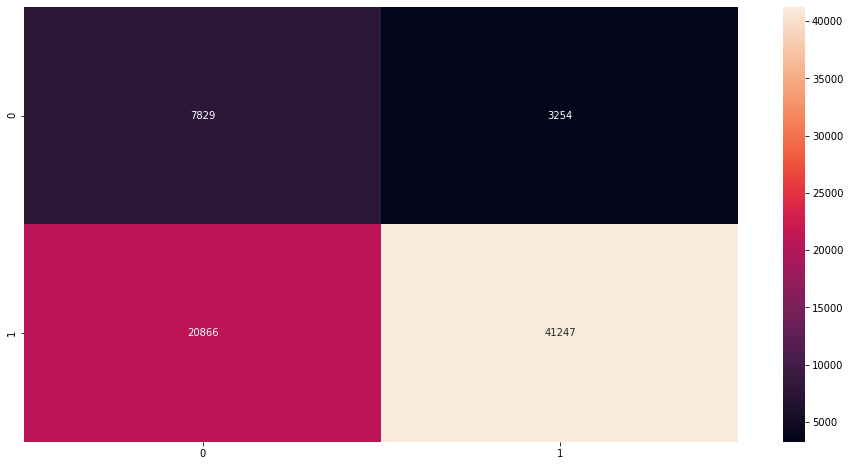

Test data confusion matrix


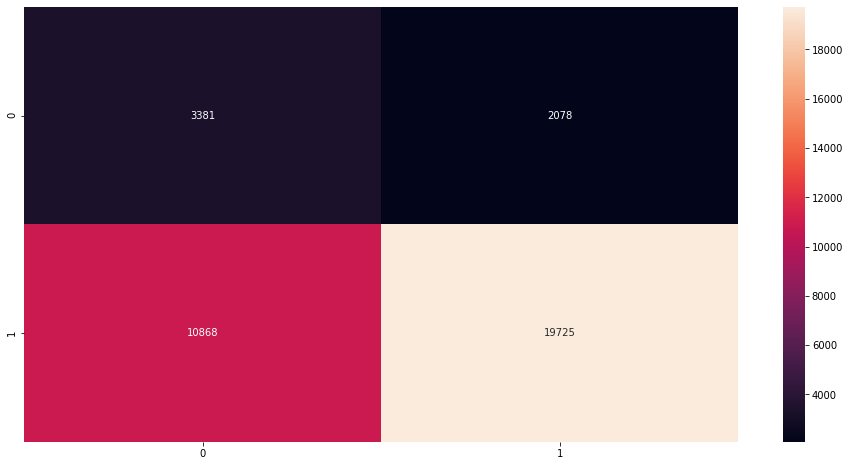

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
print("Train Data confusion matrix")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax1)


print("Test data confusion matrix")
fig = plt.figure()
ax1 = fig.add_subplot(111)
cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax1)

In [ ]:
neg_class_prob_sorted = nb_bow.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = nb_bow.feature_log_prob_[1, :].argsort()   #class1

In [ ]:
print(neg_class_prob_sorted[-10:],pos_class_prob_sorted[-10:])

[14519  8878  8228  6507  7792  9015  2875  7796 11572 12719] [14519  8878  8228  6507  7792  9015  2875  7796 11572 12719]


In [ ]:

print('Top 10 features from negative class:')
print(np.take(feature_names_bow, neg_class_prob_sorted[-10:]))
print('-*'*50)
print('Top 10 features from positive class:')
print(np.take(feature_names_tfidf, pos_class_prob_sorted[-10:]))

Top 10 features from negative class:
['workbook' 'neediest' 'maple' 'helper' 'learner' 'notably' 'classwork'
 'learniture' 'schooler' 'studies']
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Top 10 features from positive class:
['workbook' 'neediest' 'maple' 'helper' 'learner' 'notably' 'classwork'
 'learniture' 'schooler' 'studies']


In [ ]:

# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = [" Vectorizer ", " Model ", " Hyper Parameter ", " Test-AUC "]

x.add_row([" BOW ", " Naive Bayes ", 0.5, 0.7031])
x.add_row([" TFIDF ", " Naive Bayes ", 0.05, 0.6656])

print(x)

+--------------+---------------+-------------------+------------+
|  Vectorizer  |     Model     |  Hyper Parameter  |  Test-AUC  |
+--------------+---------------+-------------------+------------+
|     BOW      |  Naive Bayes  |        0.5        |   0.7031   |
|    TFIDF     |  Naive Bayes  |        0.05       |   0.6656   |
+--------------+---------------+-------------------+------------+
